<a href="https://colab.research.google.com/github/mcvlix/lorenz-96-hybrid-esn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Mount your Drive ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# === Libraries ===
import sys
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from tqdm import trange
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import linalg
from pathlib import Path
import gc
import pickle

In [3]:
# === Paths ===
project_path = '/content/drive/My Drive/AM170B Project'
data_path = os.path.join(project_path, 'data')
hybrid_states_path = os.path.join(project_path, 'hybrid_states')
states_path = os.path.join(project_path, 'states')
checkpoints_path = os.path.join(project_path, 'checkpoints')
models_path = os.path.join(project_path, 'models')
predictions_path = os.path.join(project_path, 'predictions')
plots_path = os.path.join(project_path, 'plots')
os.makedirs(states_path, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)
os.makedirs(predictions_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

In [4]:
# === View Memory Usage ===
def whos_memory(namespace):
    exclude = {
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'torch', 'sparse', 'Path',
        'exit', 'quit', 'open', 'get_ipython', 'whos_memory'
    }
    print(f"{'Variable':20} {'Type':15} {'Size (MB)':>10}")
    print("-" * 50)
    for name, val in namespace.items():
        if name.startswith("_") or name in exclude:
            continue
        try:
            size = sys.getsizeof(val) / 1024 / 1024
            print(f"{name:20} {type(val).__name__:15} {size:10.4f}")
        except Exception:
            print(f"{name:20} {type(val).__name__:15} {''}")

# del
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0001
Out                  dict                0.0001
drive                module              0.0001
cp                   module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
hybrid_states_path   str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001


### Metrics

In [108]:
def plot_nrmse_with_threshold(X_true, X_model, threshold=0.4, model_name="Model"):
    """
    Plot NRMSE over time and mark the first timestep when it exceeds a threshold.

    Assumes inputs have shape (K, T) — state dimension first, time dimension second.
    """
    # Compute RMSE at each timestep (across K)
    error = np.linalg.norm(X_true - X_model, axis=0)  # shape (T,)
    norm = np.sqrt(np.mean(np.linalg.norm(X_true, axis=0)**2))  # scalar
    nrmse = error / norm

    # Find first timestep exceeding threshold
    valid_time = np.argmax(nrmse > threshold) if np.any(nrmse > threshold) else None

    # Plotting
    plt.figure(figsize=(12, 4))
    plt.plot(nrmse, label=f"NRMSE ({model_name})")
    plt.axhline(threshold, linestyle='--', color='gray', label=f"Threshold f = {threshold}")
    if valid_time is not None:
        plt.axvline(valid_time, linestyle='--', color='red', label=f"Valid time = {valid_time}")
    plt.xlabel("Timestep")
    plt.ylabel("NRMSE")
    plt.title(f"Normalized RMSE over Time ({model_name})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return valid_time


### General Plotting Function

In [182]:
def plot_model_vs_truth(X_true, X_model, start=0, model_name="Model", valid_time=None):
    """
    Plot true vs. model predictions and difference. Shows valid time if given.
    Inputs:
    - X_true, X_model: shape (K, T)
    - start: starting timestep for title and valid_time offset
    - valid_time: int, the timestep (relative to 0) when NRMSE exceeds threshold
    """
    X_diff = X_true - X_model
    T = X_true.shape[1]
    time_axis = np.arange(T)  # Aligned x-axis: always 0 to T-1
    space_axis = np.arange(X_true.shape[0])

    fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

    # === 1. Ground Truth ===
    c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[0].set_title(f"True $X_k$ (from timestep {start})")
    axs[0].set_ylabel("$X_k$")
    axs[0].set_yticks(space_axis)
    axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c1, ax=axs[0], ticks=[-2, 0, 2])

    # === 2. Model Prediction ===
    c2 = axs[1].contourf(time_axis, space_axis, X_model, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[1].set_title(f"{model_name} $X_k$")
    axs[1].set_ylabel("$X_k$")
    axs[1].set_yticks(space_axis)
    axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c2, ax=axs[1], ticks=[-2, 0, 2])

    # === 3. Difference Plot ===
    c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[2].set_title("Difference: $X_{\\text{true}} - X_{\\text{model}}$")
    axs[2].set_xlabel("Timesteps")
    axs[2].set_ylabel("$X_k$")
    axs[2].set_yticks(space_axis)
    axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    fig.colorbar(c3, ax=axs[2], ticks=[-2, 0, 2])

    # === Add Valid Time Line ===
    if valid_time is not None:
        axs[2].axvline(x=valid_time, color='black', linestyle='--', linewidth=1.5, label=f"Valid time: t = {valid_time}")
        axs[2].legend(loc='upper right')
        axs[2].set_xticks(list(axs[2].get_xticks()) + [valid_time])

    plt.tight_layout()
    plt.show()


In [183]:
def plot_even(X_true, X_model, model_name="Model", valid_time=None):
    """
    Plots a panel of line plots comparing true and model predictions
    for even-indexed variables: X0, X2, X4, X6. Adds vertical line at valid_time if provided.
    """
    even_indices = range(0, X_true.shape[0], 2)
    num_plots = len(even_indices)
    t = np.arange(X_true.shape[1])

    fig, axs = plt.subplots(num_plots, 1, figsize=(14, 2.5 * num_plots), sharex=True)

    for i, k in enumerate(even_indices):
        axs[i].plot(t, X_true[k], label=f'True $X_{{{k}}}$', color='black')
        axs[i].plot(t, X_model[k], label=f'{model_name} $X_{{{k}}}$', linestyle='--', color='tab:red')
        if valid_time is not None:
            axs[i].axvline(x=valid_time, color='black', linestyle='--', linewidth=1.5)
        axs[i].set_ylabel(f"$X_{{{k}}}$")
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

    axs[-1].set_xlabel("Timesteps")
    fig.suptitle(f"{model_name} vs True (Even Coordinates)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()



In [184]:
def plot_odd(X_true, X_model, model_name="Model", valid_time=None):
    """
    Plots a panel of line plots comparing true and model predictions
    for odd-indexed variables: X1, X3, X5, X7. Adds vertical line at valid_time if provided.
    """
    odd_indices = range(1, X_true.shape[0], 2)
    num_plots = len(odd_indices)
    t = np.arange(X_true.shape[1])

    fig, axs = plt.subplots(num_plots, 1, figsize=(14, 2.5 * num_plots), sharex=True)

    for i, k in enumerate(odd_indices):
        axs[i].plot(t, X_true[k], label=f'True $X_{{{k}}}$', color='black')
        axs[i].plot(t, X_model[k], label=f'{model_name} $X_{{{k}}}$', linestyle='--', color='tab:blue')
        if valid_time is not None:
            axs[i].axvline(x=valid_time, color='black', linestyle='--', linewidth=1.5)
        axs[i].set_ylabel(f"$X_{{{k}}}$")
        axs[i].legend(loc='upper right')
        axs[i].grid(True)

    axs[-1].set_xlabel("Timesteps")
    fig.suptitle(f"{model_name} vs True (Odd Coordinates)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()



### Imperfect Model

In [185]:
# === Constants ===
K = 8
J = 8
F = 20
h=.5
c = 8
b = 10
dt = 0.005
T = 500000

# === Imperfect Step Function (Z excluded) ===
def x_der(x_vec, y_mat):
    y_avg = np.sum(y_mat, 0).squeeze()
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]

    x_minus = x_vec[minus]
    x_minus2 = x_vec[minus2]
    x_plus = x_vec[plus]

    dx = x_minus * (x_plus - x_minus2) - x_vec + F - (h * c / b) * y_avg
    return dx

def y_der(x_vec, y_mat):
  minus = [-1, 0, 1, 2, 3, 4, 5, 6]
  plus = [1, 2, 3, 4, 5, 6, 7, 0]
  plus2 = [2, 3, 4, 5, 6, 7, 0, 1]

  y_minus = y_mat[minus, :]
  y_plus = y_mat[plus, :]
  y_plus2 = y_mat[plus2, :]

  dy = -c * b * y_plus * (y_plus2 - y_minus) - c * y_mat + (h * c / b) * x_vec
  return dy


def x_step(x_vec, y_mat, dt_x):
    dx1 = x_der(x_vec, y_mat)
    dy1 = y_der(x_vec, y_mat)

    x_vec2 = x_vec + .5 * dt_x * dx1
    y_mat2 = y_mat + .5 * dt_x * dy1

    dx2 = x_der(x_vec2, y_mat)
    dy2 = y_der(x_vec2, y_mat2)

    x_vec3 = x_vec + .5 * dt_x * dx2
    y_mat3 = y_mat + .5 * dt_x * dy2

    dx3 = x_der(x_vec3, y_mat)
    dy3 = y_der(x_vec3, y_mat3)

    x_vec4 = x_vec + dt_x * dx3
    y_mat4 = y_mat + dt_x * dy3

    dx4 = x_der(x_vec4, y_mat)
    dy4 = y_der(x_vec4, y_mat4)

    x_vec = x_vec + dt_x / 6 * (dx1 + 2 * dx2 + 2 * dx3 + dx4)
    y_mat = y_mat + dt_x / 6 * (dy1 + 2 * dy2 + 2 * dy3 + dy4)

    return x_vec,y_mat

def imperfect_model(x_norm, y_norm, x_mean, x_std, y_mean, y_std, dt):
    """
    Propagates one timestep using the imperfect model in real space.
    """
    # Denormalize
    x_real = x_norm * x_std + x_mean
    y_real = y_norm * y_std + y_mean

    # Propagate in real space
    x_next_real, y_next_real = x_step(x_real, y_real, dt)

    # Re-normalize
    x_next_norm = (x_next_real - x_mean) / x_std
    y_next_norm = (y_next_real - y_mean) / y_std

    return x_next_norm, y_next_norm

In [186]:
# Load normalization constants
data  = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

In [187]:
print(f"x_mean: {x_mean}")
print(f"x_std: {x_std}")
print(f"y_mean: {y_mean}")
print(f"y_std: {y_std}")

x_mean: 3.4445883001855693
x_std: 7.100911457563861
y_mean: 0.16719724830104818
y_std: 0.27036501240689953


In [188]:
# Parameters
start_idx = 500000
n_steps = 1000

# === Extract Initial Normalized State ===
x_curr = data[start_idx, :K]
y_curr = data[start_idx, K:].reshape(J, K, order='F')

# === Run Imperfect Model ===
X_model_preds = np.zeros((K, n_steps))

# Run simulation
for t in tqdm(range(n_steps), desc="Running Imperfect Model"):
    X_model_preds[:, t] = x_curr
    x_curr, y_curr = imperfect_model(x_curr, y_curr, x_mean, x_std, y_mean, y_std, dt)

Running Imperfect Model: 100%|██████████| 1000/1000 [00:00<00:00, 5814.26it/s]


In [189]:
# === Slice Ground Truth to Compare ===
X_true_slice = data[start_idx : start_idx + n_steps, :K].T  # shape: (K, n_steps)

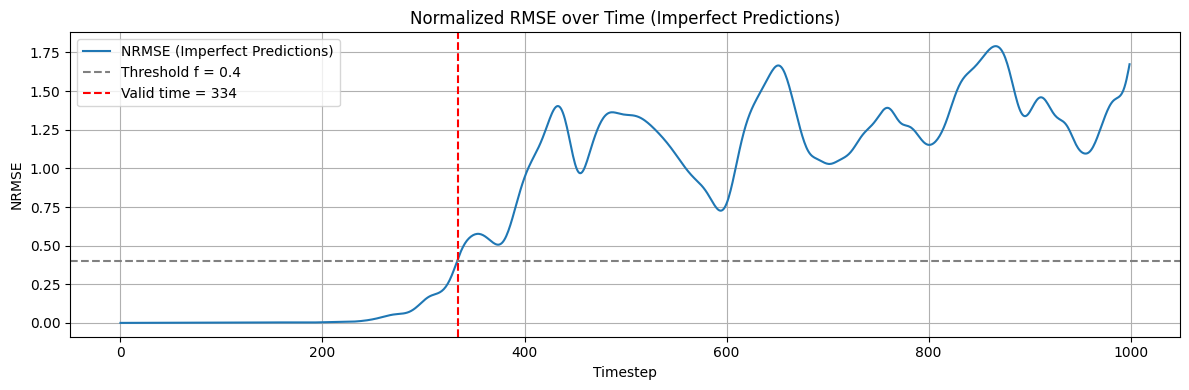

334


In [190]:
# === Plot and Calculate Valide Time ===
valid_time = plot_nrmse_with_threshold(X_true_slice, X_model_preds, threshold=0.4, model_name="Imperfect Predictions")
print(valid_time)

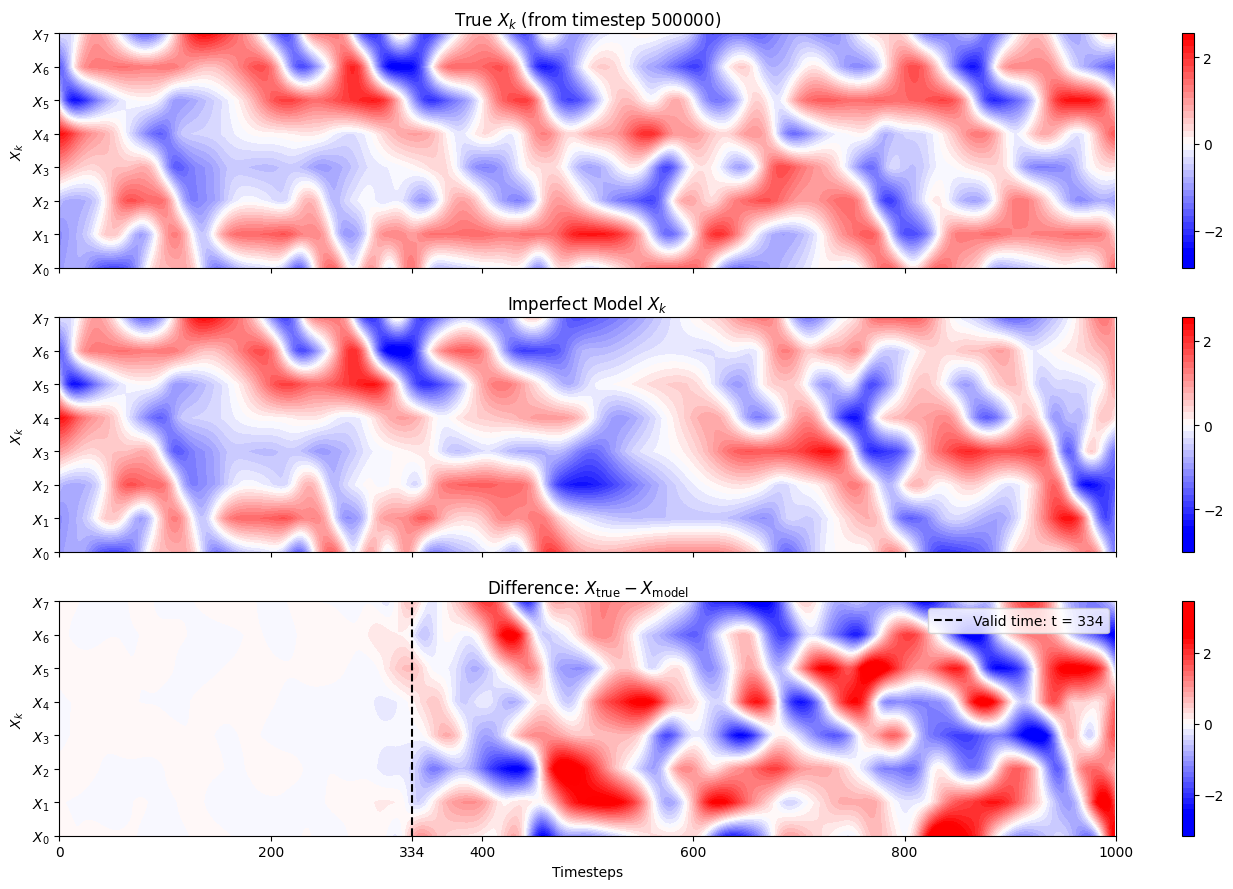

In [191]:
# === Plot Comparison ===
plot_model_vs_truth(X_true_slice, X_model_preds, start=start_idx, model_name="Imperfect Model", valid_time=valid_time)

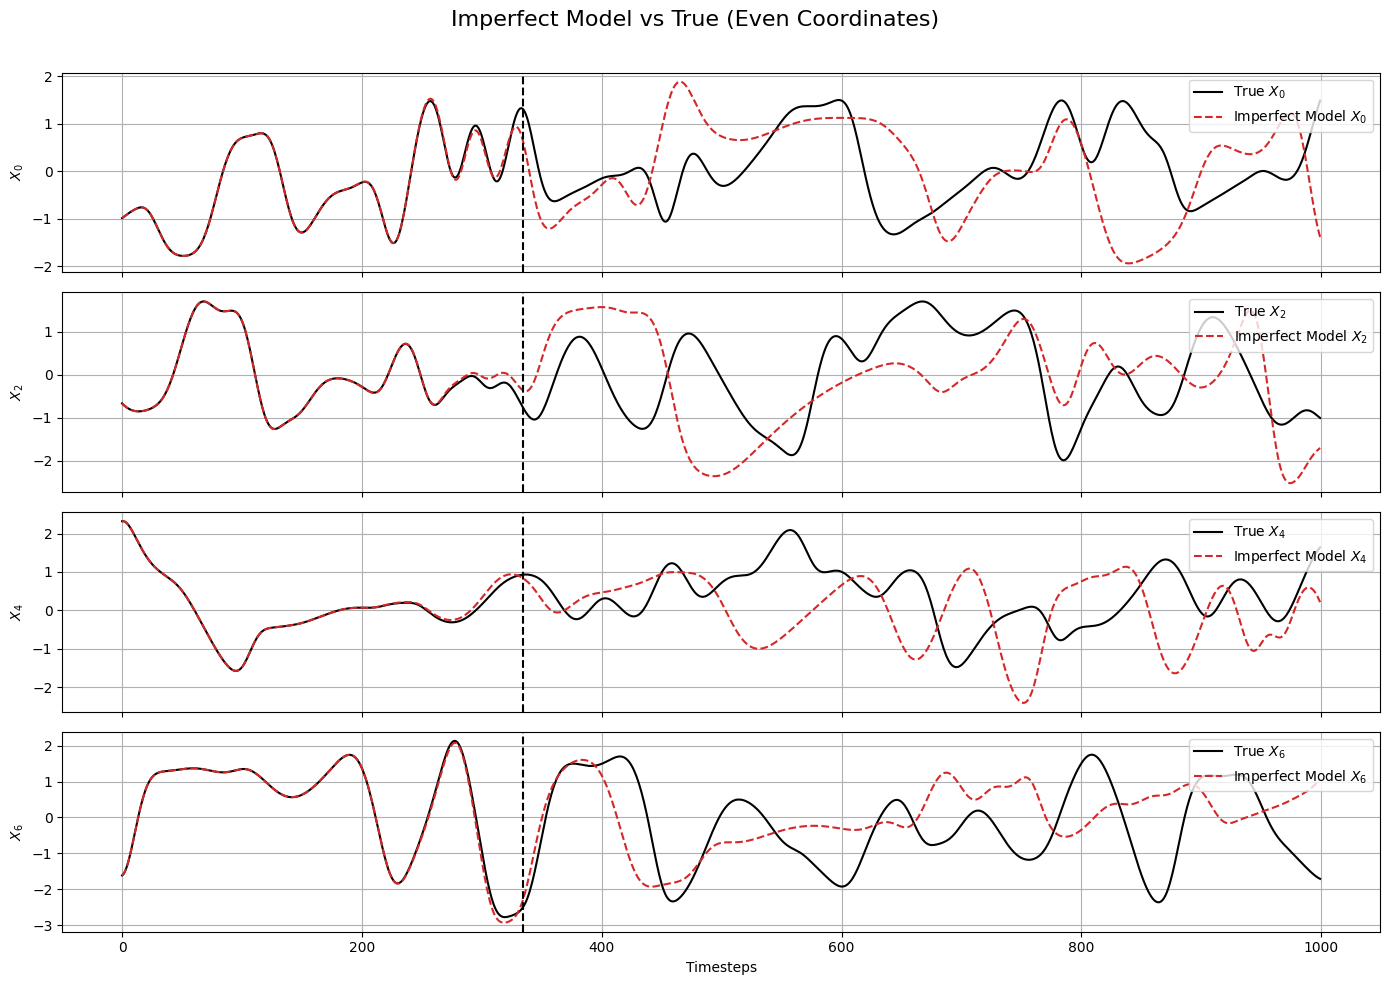

In [192]:
plot_even(X_true_slice, X_model_preds, model_name="Imperfect Model", valid_time=valid_time)

### ESN

In [193]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 8,
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

In [194]:
def predict_esn(A, Win, W_out, res_params, r_state, start_idx, r_idx, X_true=None):
    """
    Pure ESN prediction with optional warm-up.
    """
    N = res_params['N']
    K = res_params['num_inputs']
    T_pred = res_params['predict_length']

    x = r_state.copy()
    output = np.zeros((K, T_pred))

    # === Warm-up (optional) ===
    if start_idx > r_idx:
        assert X_true is not None, "X_true must be provided for warm-up"
        for t in range(start_idx - r_idx):
            out = X_true[t]
            x = np.tanh(A @ x + Win @ out)
        print(f"[ESN] Warmed reservoir from t={r_idx} to t={start_idx}")

    # === Prediction ===
    out = X_true[start_idx - r_idx] if X_true is not None else np.zeros(K)  # reasonable default
    for t in tqdm(range(T_pred), desc="ESN Prediction"):
        # Augment for r* transformation
        x_aug = x.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                x_aug[j] = x[j - 1] * x[j - 2]

        out = W_out @ x_aug
        output[:, t] = out
        x = np.tanh(A @ x + Win @ out)

    return output

In [195]:
data  = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

In [196]:
# Load model
model = np.load(os.path.join(models_path, 'model_500000.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# Prediction config
res_params['predict_length'] = 1000
r_idx = 500000
start_idx = 500000 # or same as r_idx if continuing immediately

# Load final reservoir state from last training chunk
last_state_file = os.path.join(states_path, f'states_chunk_009.npz')  # 10th chunk (index 0–9)
r_state = np.load(last_state_file)['states'][:, -1]

# Optional warm-up data
X_warm = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')[r_idx:start_idx + 1, :8]

# Run prediction
X_preds = predict_esn(A, Win, W_out, res_params, r_state, start_idx, r_idx, X_warm)

ESN Prediction: 100%|██████████| 1000/1000 [00:09<00:00, 103.39it/s]


In [27]:
# === Save Predictions (optional) ===

# np.savez_compressed(
#     os.path.join(predictions_path, f'esn_prediction_start{start_idx}_len{res_params["predict_length"]}.npz'),
#     X_true=X_true,
#     X_pred=X_preds,
#     X_diff=X_diff,
#     start=start_idx,
#     length=res_params['predict_length']
# )

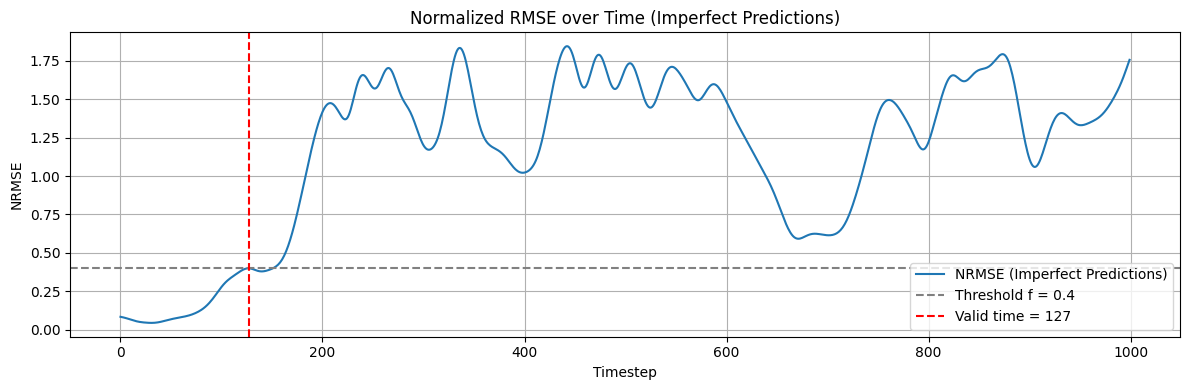

127


In [197]:
# === Plot and Calculate Valide Time ===
X_true = data[start_idx:start_idx + res_params['predict_length'], :8].T
valid_time = plot_nrmse_with_threshold(X_true, X_preds, threshold=0.4, model_name="Imperfect Predictions")
print(valid_time)

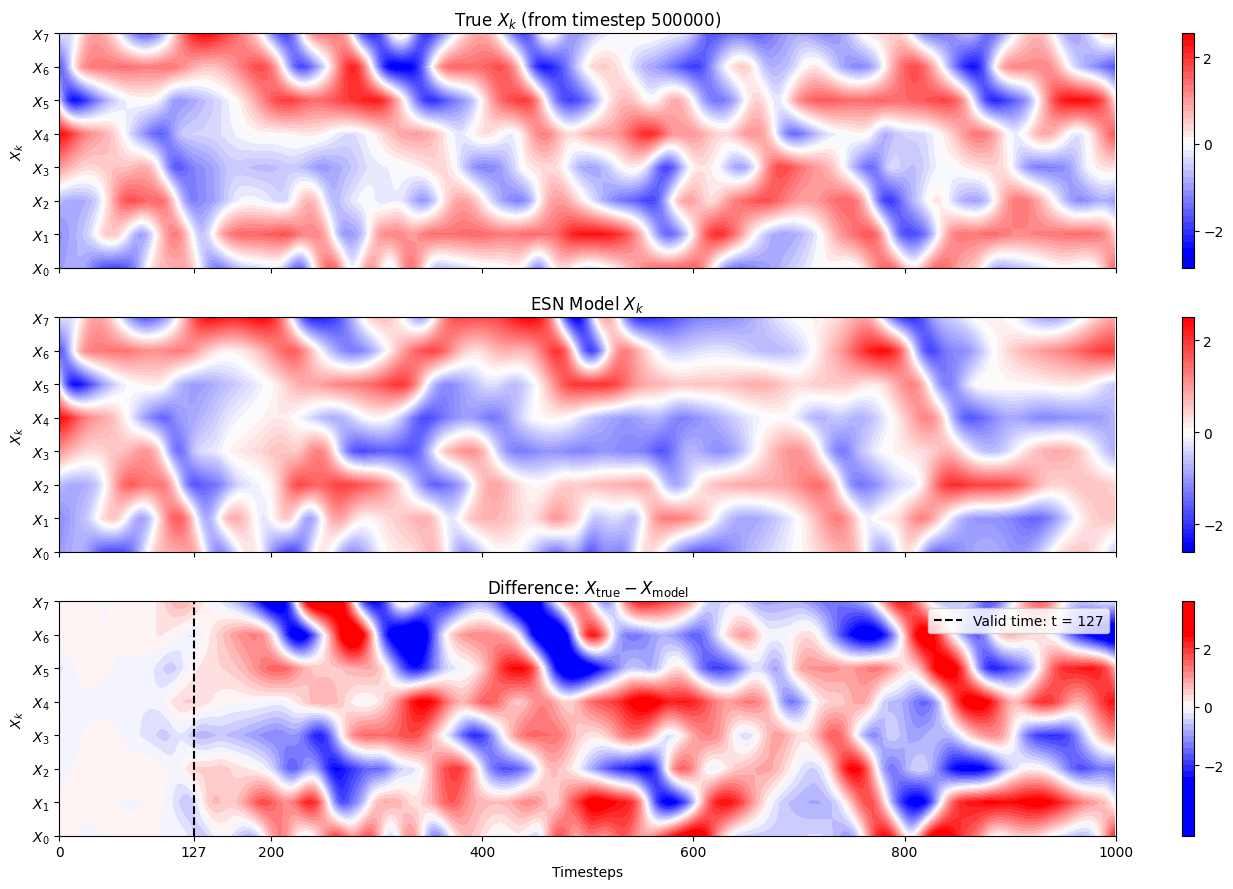

In [198]:
# === Plot Comparison ===
plot_model_vs_truth(X_true, X_preds, start=start_idx, model_name="ESN Model", valid_time=valid_time)

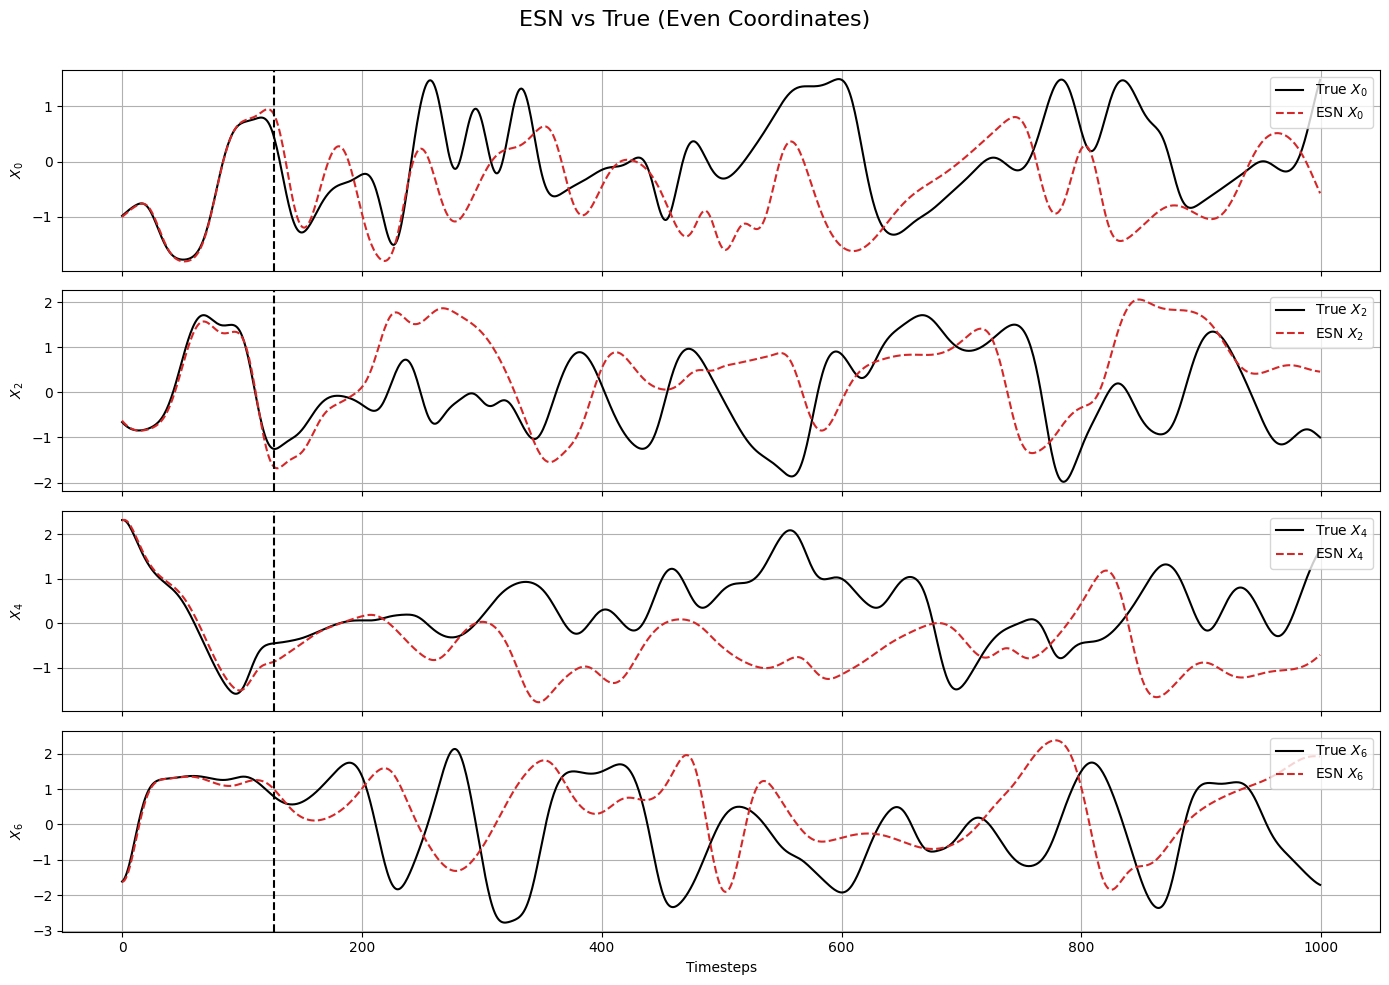

In [199]:
plot_even(X_true, X_preds, model_name="ESN", valid_time=valid_time)

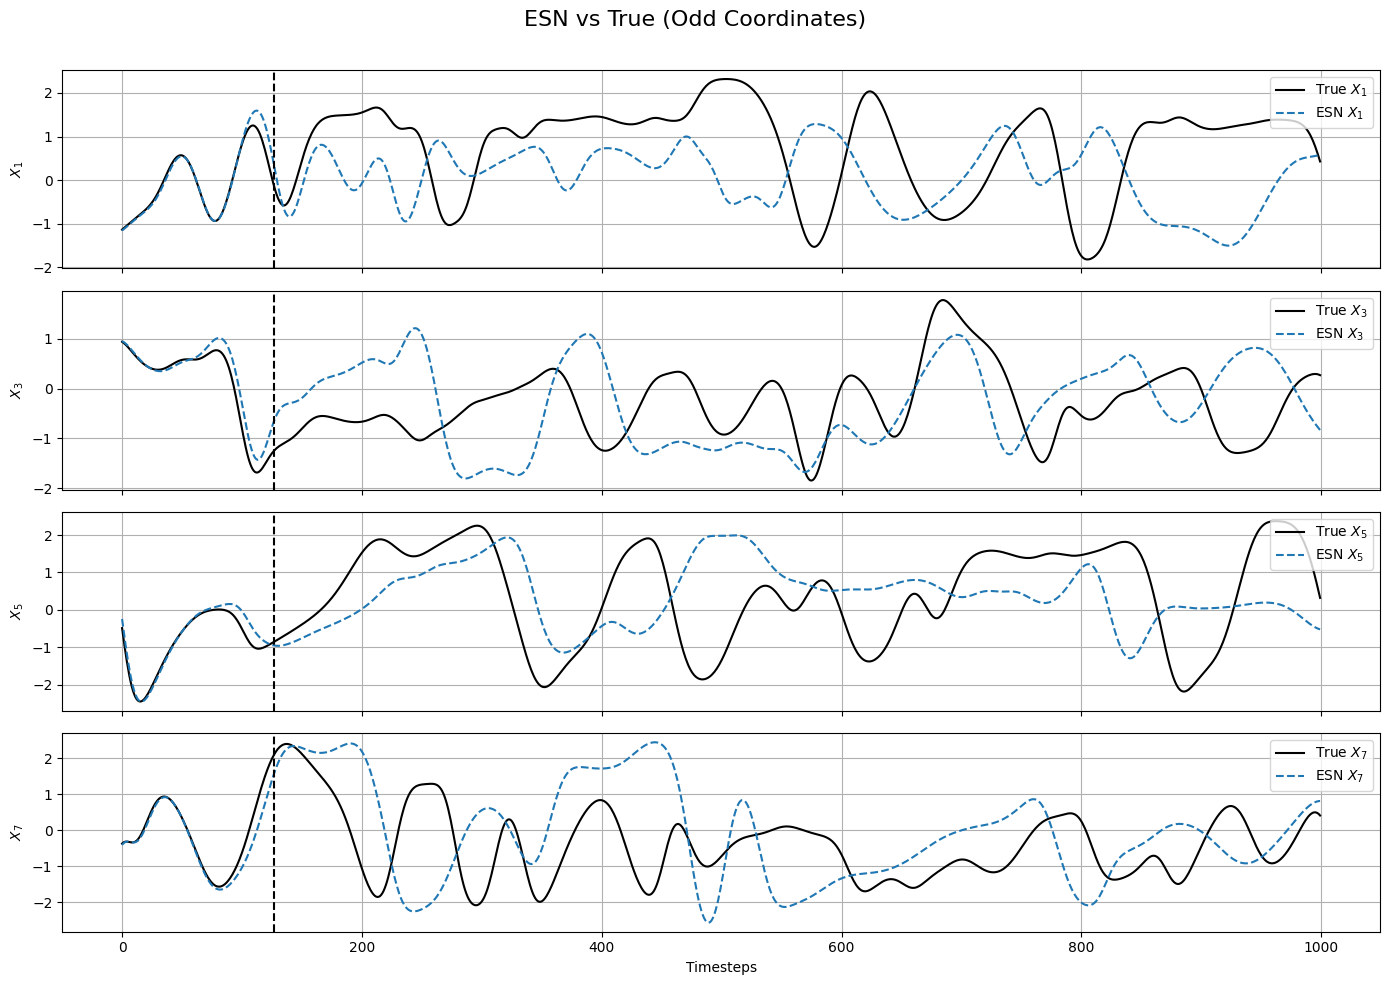

In [200]:
plot_odd(X_true, X_preds, model_name="ESN", valid_time=valid_time)

### Hybrid ESN

### EnKF

In [11]:
class EnKF:
    def __init__(self, Ne, H, R):
        self.Ne = Ne
        self.H = H
        self.R = R
        self.ensemble = None
        self.x_mean = []
        self.x_ens = []

    def initialize_ensemble(self, x0, P0):
        self.ensemble = np.random.multivariate_normal(x0, P0, self.Ne)

    def predict(self, forecasted_x):
        for i in range(self.Ne):
            self.ensemble[i] = forecasted_x + np.random.normal(0, 0.5, forecasted_x.shape)

    def update(self, observation):
        X = self.ensemble.T
        x_mean = np.mean(X, axis=1, keepdims=True)
        X_prime = X - x_mean

        HX = self.H @ X
        y_mean = np.mean(HX, axis=1, keepdims=True)
        Y_prime = HX - y_mean

        P_xy = X_prime @ Y_prime.T / (self.Ne - 1)
        P_yy = Y_prime @ Y_prime.T / (self.Ne - 1) + self.R
        K = P_xy @ np.linalg.inv(P_yy)

        for i in range(self.Ne):
            perturb = np.random.multivariate_normal(np.zeros(self.R.shape[0]), self.R)
            innovation = observation + perturb - HX[:, i]
            X[:, i] += K @ innovation

        self.ensemble = X.T
        self.x_mean.append(np.mean(self.ensemble, axis=0))
        self.x_ens.append(np.copy(self.ensemble))

    def get_results(self):
        return np.array(self.x_mean), np.array(self.x_ens)

In [201]:
data  = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))
x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

In [202]:
true_states = data[:1000, :K]  # normalized true x values
obs_every = 10
R = np.eye(K) * 0.01

observations = np.full_like(true_states, np.nan)

for t in range(0, len(true_states), obs_every):
    observations[t] = true_states[t] + np.random.multivariate_normal(np.zeros(K), R)
observations.shape

(1000, 8)

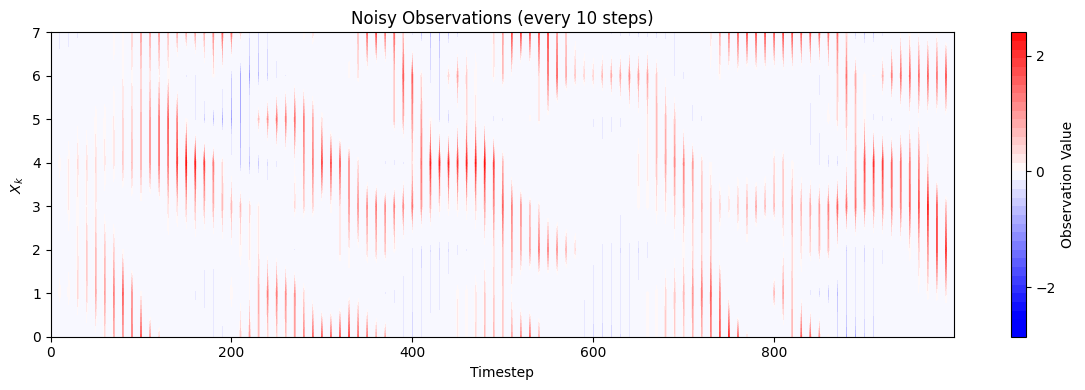

In [203]:
observations_for_plot = np.where(np.isnan(observations), 0, observations).T  # shape: (K, T)
plt.figure(figsize=(12, 4))
contour = plt.contourf(
    np.arange(observations_for_plot.shape[1]),  # time
    np.arange(K),                               # channel index
    observations_for_plot,
    levels=50, cmap='bwr', vmin=-2.5, vmax=2.5
)
plt.title("Noisy Observations (every 10 steps)")
plt.xlabel("Timestep")
plt.ylabel("$X_k$")

# Set colorbar with fixed ticks
cbar = plt.colorbar(contour)
cbar.set_ticks([-2, 0, 2])
cbar.set_label("Observation Value")

plt.tight_layout()
plt.show()

### Imperfect Model + EnKF

In [204]:
def imperfect_enkf_forecast(X_init, Y_init, observations, enkf, x_mean, x_std, y_mean, y_std, dt):
    """
    Propagate the imperfect model and use EnKF to correct every obs_every steps.
    """
    T = observations.shape[0]
    K = X_init.shape[0]
    X = X_init.copy()
    Y = Y_init.copy()

    X_preds = np.zeros((T, K))

    for t in trange(T):
        # Step the imperfect model
        X, Y = imperfect_model(X, Y, x_mean, x_std, y_mean, y_std, dt)

        # Pass the model forecast to EnKF
        enkf.predict(X)

        # If we have an observation, use it to correct X
        if not np.isnan(observations[t, 0]):
            enkf.update(observations[t])
            X = enkf.x_mean[-1]  # Replace X with filtered ensemble mean

        X_preds[t] = X  # Store the current corrected prediction

    enkf_mean, enkf_ens = enkf.get_results()
    return X_preds, enkf_mean, enkf_ens


In [205]:
# === Load Normalized Ground Truth ===
data  = np.load(os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy'), mmap_mode='r')
norms = np.load(os.path.join(data_path, 'norm_constants_h_0.5_c_8_F_20.npz'))

x_mean, x_std = norms['x_mean'], norms['x_std']
y_mean, y_std = norms['y_mean'], norms['y_std']

In [222]:
# === Constants ===
K = 8
J = 8
F = 20
h=.5
c = 8
b = 10
dt = 0.005
start_idx = 500000
T = 1000

# === Extract Initial Conditions ===
X_init = data[start_idx, :K]
Y_init = data[start_idx, K:].reshape(J, K, order='F')
true_states = data[start_idx : start_idx + T, :K]

In [231]:
# === Create Noisy Observations (every 10 steps) ===
obs_every = 20
R = np.eye(K) * 0.01

observations = np.full_like(true_states, np.nan)
for t in trange(0, T, obs_every):
    observations[t] = true_states[t] + np.random.multivariate_normal(np.zeros(K), R)

100%|██████████| 50/50 [00:00<00:00, 7661.11it/s]


In [232]:
# === Initialize EnKF ===
Ne = 100
H = np.eye(K)
P0 = np.eye(K)
enkf = EnKF(Ne=Ne, H=H, R=R)
enkf.initialize_ensemble(X_init, P0)

In [233]:
# === Run Forecast ===
X_preds, enkf_mean, enkf_ens = imperfect_enkf_forecast(
    X_init, Y_init, observations, enkf,
    x_mean, x_std, y_mean, y_std, dt
)

100%|██████████| 1000/1000 [00:01<00:00, 998.98it/s]


In [234]:
X_true = true_states[:T, :K].T
X_model = X_preds.T  # or enkf_mean.T
print(f"X_true shape: {X_true.shape}")
print(f"X_model shape: {X_model.shape}")

X_true shape: (8, 1000)
X_model shape: (8, 1000)


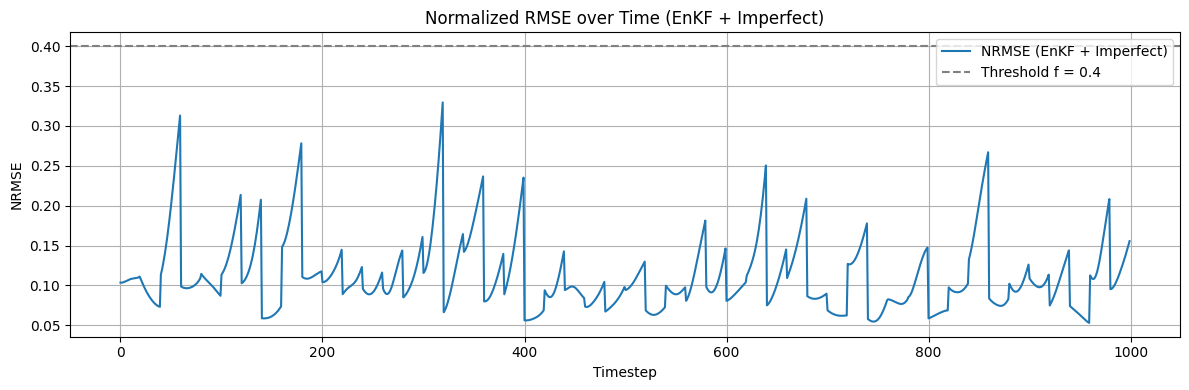

None


In [235]:
valid_time = plot_nrmse_with_threshold(X_true, X_model, threshold=0.4, model_name="EnKF + Imperfect")
print(valid_time)

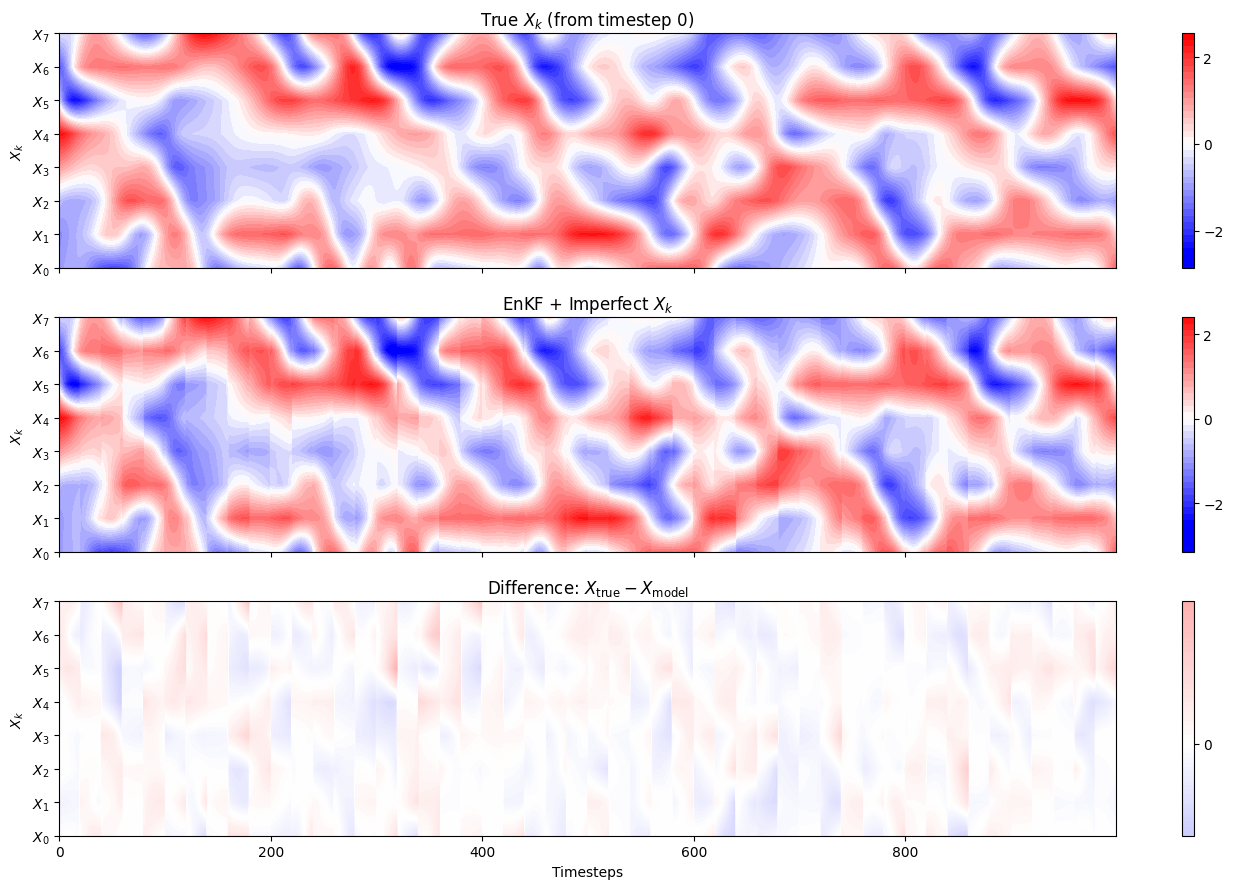

In [236]:
plot_model_vs_truth(X_true, X_model, model_name="EnKF + Imperfect", valid_time=valid_time)

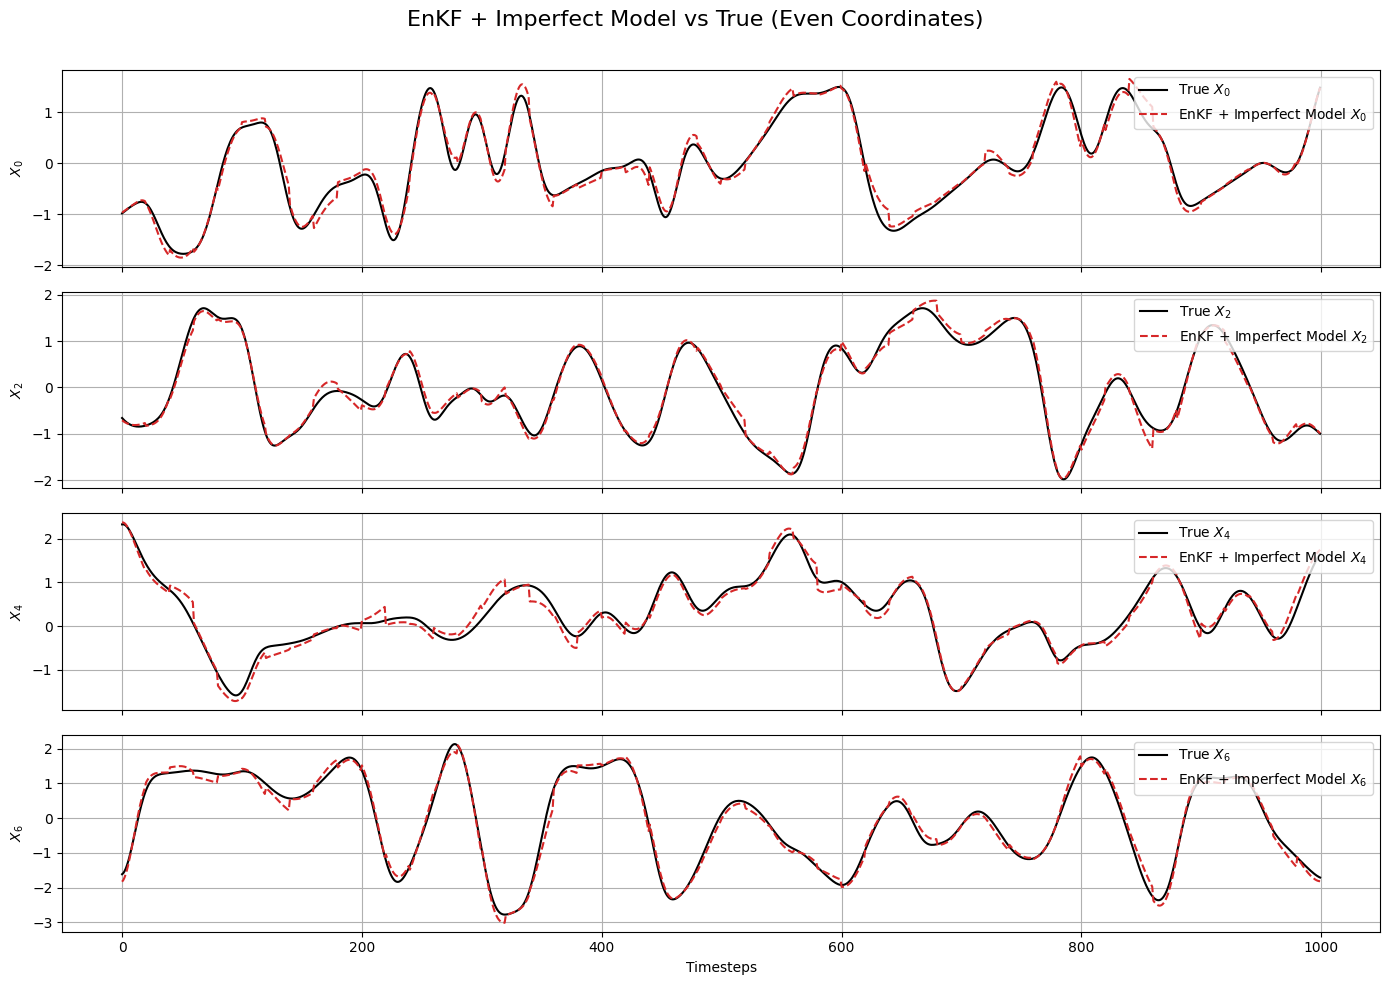

In [237]:
plot_even(X_true, X_model, model_name="EnKF + Imperfect Model")

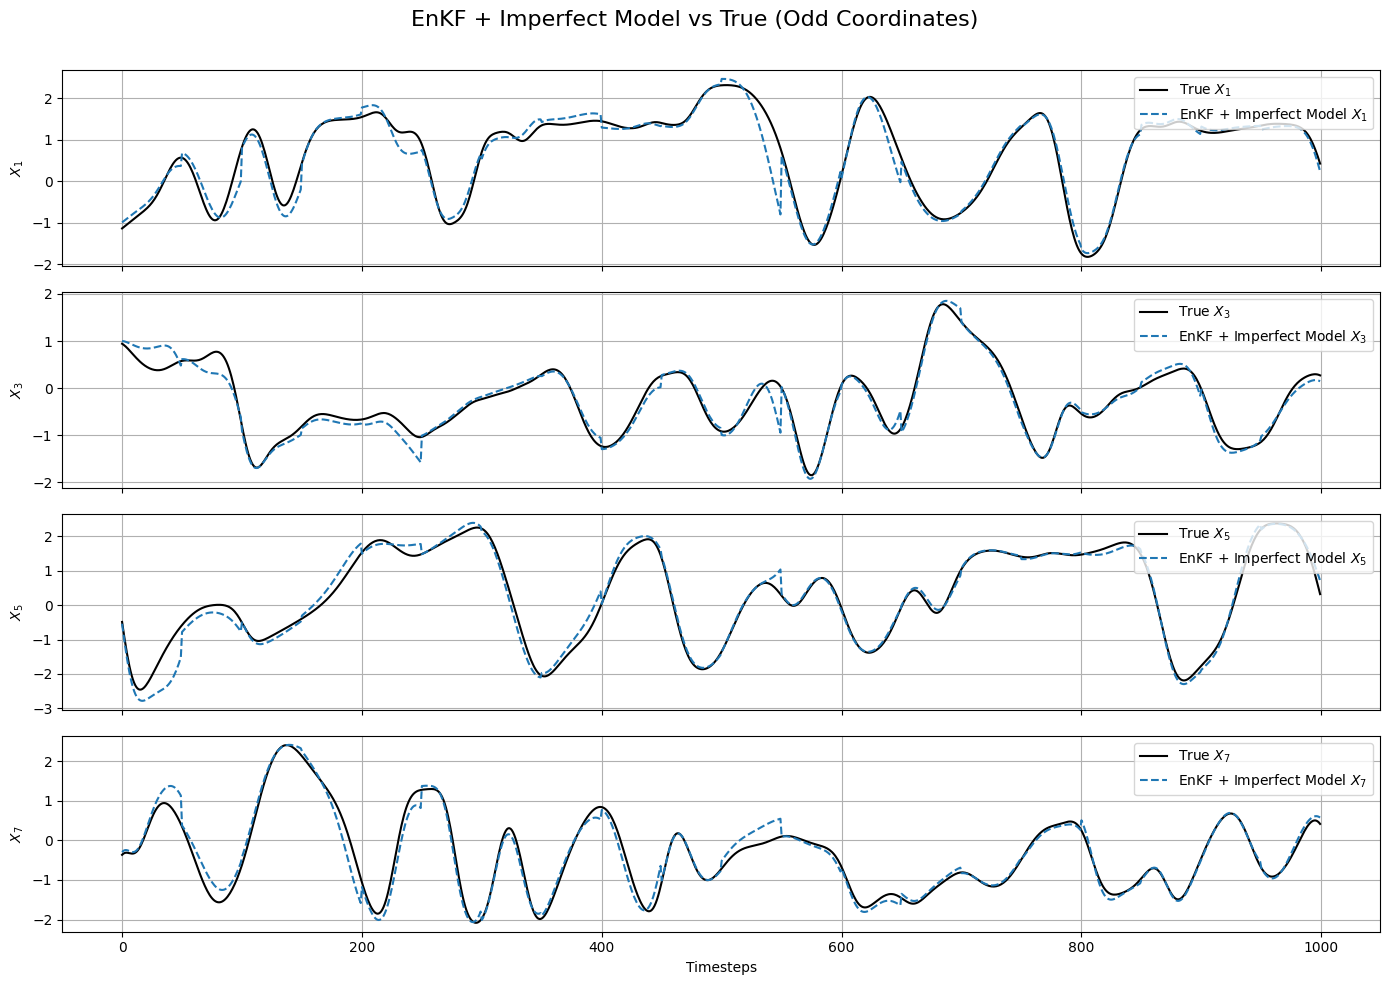

In [230]:
plot_odd(X_true, X_model, model_name="EnKF + Imperfect Model")

### ESN + EnKF

### Hybrid ESN + EnKF